<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [48]:
from dataclasses import dataclass
import numpy as np
from scipy.constants import c as c_light
from scipy.integrate import quad
from scipy.special import exp1, expi, gammaincc
from scipy.special import comb
import logging
import matplotlib.pyplot as plt

from optic.comm.modulation import modulateGray, demodulateGray, grayMapping, detector
from optic.comm.metrics import fastBERcalc, theoryBER
from optic.models.channels import awgn
from optic.dsp.core import pnorm, signal_power
from optic.plot import pconst, plotDecisionBoundaries, randomCmap, plotColoredConst
from optic.utils import dB2lin

In [78]:
@dataclass
class PertCoeffParams:
    alpha: float           # Attenuation [dB/km]
    D: float               # Dispersion [ps/(nm.km)]
    Fc: float              # CArrier Frequency [nm]
    lspan: float           # Span length [km]
    length: float          # Total link length [km]
    matrixOrder: int       # Matrix order
    pulseWidth: float      # Pulse width [s]
    symbolPeriod: float    # Symbol period [s]
    gamma: float           # Nonlinear coefficient [1/(W.km)]
    powerWeighted: bool    # Use power weighted calculation?
    powerWeightN: int = 3  # Order of power weighting (default = 3)

def pert_coeff_matrix(param: PertCoeffParams):
    # Setup logging
    logging.basicConfig(level=logging.INFO)
    log = logging.getLogger()
    c_kms = c_light / 1e3
    
    # Link parameters
    λ = c_kms/param.Fc
    alpha = param.alpha / (10 * np.log10(np.e))
    beta2 = -param.D * λ**2 / (2 * np.pi * c_kms)
    Leff = (1 - np.exp(-alpha * param.lspan)) / alpha
    nSpans = int(param.length / param.lspan)

    # Matrix indices
    m_vals = np.arange(-param.matrixOrder, param.matrixOrder + 1)
    M, N = np.meshgrid(m_vals, m_vals[::-1])

    # Calculate C_ispm
    constantIntegral = param.pulseWidth**4 / (3 * beta2**2)
    fun1 = lambda z, c: 1.0 / np.sqrt(c + z**2)
    C_ispm, _ = quad(lambda z: fun1(z, constantIntegral), 0, param.length)

    # Calculate C_ifwm
    if param.powerWeighted:
        Acoeff = M * N * param.symbolPeriod**2 / beta2
        sum1 = np.zeros_like(M, dtype=complex)
        Norder = param.powerWeightN

        log.info('Calculating matrix of perturbation coefficients (power-weighted)...')
        for indSpan in range(1, nSpans + 1):
            Bcoeff = -Norder / (alpha * Acoeff) + ((indSpan - 1) * param.lspan) / Acoeff

            sum2 = np.zeros_like(M, dtype=complex)
            for kk in range(1, Norder + 1):
                if indSpan != 1:
                    GammaPrevious = gammaincc(1 - kk, 1j * (1 / Bcoeff - Acoeff / ((indSpan - 1) * param.lspan)))
                else:
                    GammaPrevious = np.zeros_like(M, dtype=complex)
                GammaNext = gammaincc(1 - kk, 1j * (1 / Bcoeff - Acoeff / (indSpan * param.lspan)))

                term = (-1)**(kk + Norder) * comb(Norder - 1, kk - 1) * (1j / Bcoeff)**kk * (GammaPrevious - GammaNext)

                if kk == 1:
                    sum2 = term
                else:
                    sum2 += term

            if indSpan == 1:
                sum1 = (np.exp(1j / Bcoeff) / Bcoeff**(Norder - 1)) * sum2
            else:
                sum1 += (np.exp(1j / Bcoeff) / Bcoeff**(Norder - 1)) * sum2

        C_ifwm = (Norder / alpha)**Norder * (Acoeff**-Norder) * sum1
    else:
        log.info('Calculating matrix of perturbation coefficients (standard)...')
        C_ifwm = exp1(-1j * M * N * param.symbolPeriod**2 / (beta2 * param.length))

    # Calculate C_ixpm
    C_ixpm = 0.5 * exp1((N - M)**2 * param.symbolPeriod**2 * param.pulseWidth**2 / (3 * np.abs(beta2)**2 * param.length**2))
     
    # Handle inf and nan values
    if param.powerWeighted:
        C_ifwm_mask = np.isnan(np.abs(C_ifwm)).astype(float)
        C_ifwm[np.isnan(np.abs(C_ifwm))] = 0
    else:
        C_ifwm_mask = np.isinf(np.abs(C_ifwm)).astype(float)
        C_ifwm[np.isinf(np.abs(C_ifwm))] = 0

    C_ixpm[np.isinf(np.abs(C_ixpm))] = 0
    C_ixpm = C_ifwm_mask * C_ixpm

    # Scale the matrices
    scale_factor = 1j * (8/9) * param.gamma * param.pulseWidth**2 / (np.sqrt(3) * np.abs(beta2)) * Leff / param.lspan
    if param.powerWeighted:
        C_ifwm = -(8/9) * param.gamma * param.pulseWidth**2 / (np.sqrt(3) * beta2) * C_ifwm
        C_ixpm = scale_factor * C_ixpm
        C_ispm = scale_factor * C_ispm
    else:
        C_ifwm = scale_factor * C_ifwm
        C_ixpm = scale_factor * C_ixpm
        C_ispm = scale_factor * C_ispm

    # Combine results
    C = C_ifwm + C_ixpm
    C[param.matrixOrder, param.matrixOrder] = C_ispm

    log.info('Matrix of perturbation coefficients calculated. Dimensions: %d x %d', 2 * param.matrixOrder + 1, 2 * param.matrixOrder + 1)

    return C, C_ifwm, C_ixpm, C_ispm

def additive_multiplicative_model_nlin_waveform(C_ifwm, C_ixpm, C_ispm, x, y):
    # Definitions
    L = (len(C_ifwm) - 1) // 2
    D = len(C_ifwm) - 1

    C = C_ifwm + C_ixpm
    C[D, D] = C_ispm
    C_m_non_equal_zero = C.copy()
    C_m_non_equal_zero[:, L] = np.zeros(D+1)

    C_ixpm_mask1 = C_ixpm * np.isinf(1.0 / C_m_non_equal_zero.T)
    C_ixpm_mask2 = C_ixpm * np.isinf(1.0 / C_m_non_equal_zero)

    # Normalize power to 1
    x = norm_power(x)
    y = norm_power(y)

    # Variable initializations
    dx = np.zeros(len(x), dtype=complex)
    dy = np.zeros(len(y), dtype=complex)
    phi_ixpm_x = np.zeros(len(x))
    phi_ixpm_y = np.zeros(len(y))

    symbX = np.concatenate((np.zeros(D, dtype=complex), x, np.zeros(D, dtype=complex)))
    symbY = np.concatenate((np.zeros(D, dtype=complex), y, np.zeros(D, dtype=complex)))

    # Create indexing matrices
    ind = np.arange(2*L+1)
    M = np.tile(ind, (len(ind), 1))
    NplusM = -((M.T - L) + (M - L)) + len(C) - 1
    NplusM = np.flipud(np.rot90(NplusM, 2))
    
    # Flatten matrices
    C_ixpm_mask1 = C_ixpm_mask1.flatten()
    C_ixpm_mask2 = C_ixpm_mask2.flatten()
    C_ifwm = C_ifwm.flatten()

    center_offset = (len(symbX) - 1) // 2

    # Main loop
    for t in range(D, len(symbX) - D):
        x_2d = symbX[t - D:t + D + 1]
        y_2d = symbY[t - D:t + D + 1]
        
        X_NplusM = x_2d[NplusM]
        Y_NplusM = y_2d[NplusM]

        center = (len(x_2d) - 1) // 2
        Xn = np.tile(x_2d[center - L:center + L + 1], (len(ind), 1)).T
        Yn = np.tile(y_2d[center - L:center + L + 1], (len(ind), 1)).T
        Xm = np.tile(x_2d[center - L:center + L + 1], (len(ind), 1))
        Ym = np.tile(y_2d[center - L:center + L + 1], (len(ind), 1))

        Xn = np.flipud(Xn)
        Yn = np.flipud(Yn)

        DX = (Xn * np.conj(X_NplusM) * Xm + Yn * np.conj(Y_NplusM) * Xm)
        DY = (Yn * np.conj(Y_NplusM) * Ym + Xn * np.conj(X_NplusM) * Ym)

        DX_vec = DX.flatten()
        DY_vec = DY.flatten()

        Xm2 = np.abs(Xm)**2
        Ym2 = np.abs(Ym)**2

        phi_ixpm_x[t - D] = np.imag(np.sum((2 * Xm2 + Ym2).flatten() * C_ixpm_mask1) + (np.abs(Xm[L, L])**2 + np.abs(Ym[L, L])**2) * C_ispm)
        phi_ixpm_y[t - D] = np.imag(np.sum((2 * Ym2 + Xm2).flatten() * C_ixpm_mask1) + (np.abs(Ym[L, L])**2 + np.abs(Xm[L, L])**2) * C_ispm)

        dx[t - D] = np.dot(DX_vec, C_ifwm) + np.dot((Yn * np.conj(Y_NplusM) * Xm).flatten(), C_ixpm_mask2)
        dy[t - D] = np.dot(DY_vec, C_ifwm) + np.dot((Xn * np.conj(X_NplusM) * Ym).flatten(), C_ixpm_mask2)

    return dx, dy, phi_ixpm_x, phi_ixpm_y

def norm_power(signal):
    """Normalize signal power to 1."""
    power = np.mean(np.abs(signal)**2)
    return signal / np.sqrt(power)


INFO:root:Calculating matrix of perturbation coefficients (standard)...
INFO:root:Matrix of perturbation coefficients calculated. Dimensions: 51 x 51


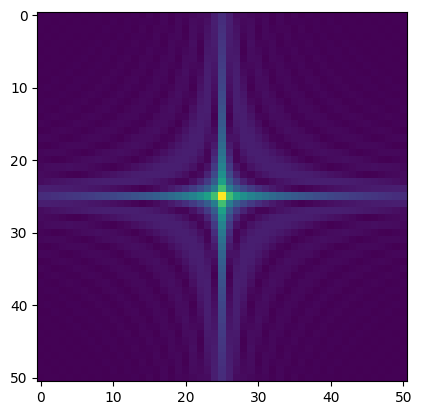

In [79]:
# Exemplo de como instanciar e chamar
params = PertCoeffParams(
    alpha=0.2,
    D = 17,
    Fc = 193.1e12,     # km
    lspan=50,
    length=800,
    matrixOrder=25,
    pulseWidth=0.5*1/32e9,
    symbolPeriod=1/32e9,
    gamma=1.3,
    powerWeighted=False
)

C, C_ifwm, C_ixpm, C_ispm = pert_coeff_matrix(params)

plt.figure()
plt.imshow(np.abs(np.imag(C)))
#plt.imshow(np.abs(C_ispm))

In [80]:
# Run simulation 
M   = 16  # order of the modulation format
constType = 'qam' # 'qam', 'psk', 'apsk', 'pam' or 'ook'

# generate random bits
bitsX = np.random.randint(2,size =int(np.log2(M)*1e4))
bitsY = np.random.randint(2,size =int(np.log2(M)*1e4))

# Map bits to constellation symbols
symbX = modulateGray(bitsX, M, constType)
symbY = modulateGray(bitsY, M, constType)

# normalize symbols energy to 1
symbX = pnorm(symbX)
symbY = pnorm(symbY)

In [90]:
Power = 1 # dBm

dx, dy, phi_ixpm_x, phi_ixpm_y = additive_multiplicative_model_nlin_waveform(C_ifwm, C_ixpm, C_ispm, symbX, symbY)

Plaunch = 10**(Power / 10) * 1e-3  # Calcula a potência de lançamento em Watts
PeakPower = 0.5 * Plaunch               # Potência de pico por polarização, em Watts

deltaX = PeakPower**(3/2) * dx
deltaY = PeakPower**(3/2) * dy
phiX = PeakPower * phi_ixpm_x
phiY = PeakPower * phi_ixpm_y

nlinX = symbX * (np.exp(1j * phiX) - 1) + deltaX * np.exp(1j * phiX)
nlinY = symbY * (np.exp(1j * phiY) - 1) + deltaY * np.exp(1j * phiY)

C:\Users\edson\AppData\Local\Temp\ipykernel_30396\2548296464.py:115: RuntimeWarning: divide by zero encountered in divide
  C_ixpm_mask1 = C_ixpm * np.isinf(1.0 / C_m_non_equal_zero.T)
C:\Users\edson\AppData\Local\Temp\ipykernel_30396\2548296464.py:115: RuntimeWarning: invalid value encountered in divide
  C_ixpm_mask1 = C_ixpm * np.isinf(1.0 / C_m_non_equal_zero.T)
C:\Users\edson\AppData\Local\Temp\ipykernel_30396\2548296464.py:116: RuntimeWarning: divide by zero encountered in divide
  C_ixpm_mask2 = C_ixpm * np.isinf(1.0 / C_m_non_equal_zero)
C:\Users\edson\AppData\Local\Temp\ipykernel_30396\2548296464.py:116: RuntimeWarning: invalid value encountered in divide
  C_ixpm_mask2 = C_ixpm * np.isinf(1.0 / C_m_non_equal_zero)


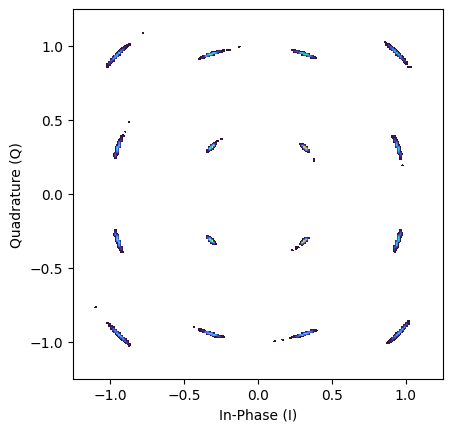

In [92]:
rot = np.mean(symbX / (symbX + nlinX))

symbX_r = np.exp(1j*np.angle(rot)) * (symbX + nlinX)

pconst(symbX_r);